In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io
from tqdm import tqdm

import random

from nltk.tokenize import word_tokenize

# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import KFold

# import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps')

In [3]:
class Config:
    block_size = 256
    batch_size = 64

    dropout = 0.2

    device=device
    split=0.9

    def __init__(self):
        pass

config = Config()

# Timeseries Data 

In [4]:
# def saw(x):
#     x = np.mod(x, 2)
#     x = (np.where(x > 1, 2-x, x) - 0.5) * 2

#     return x

In [4]:
# class ArtificialDataset(Dataset):
#     def __init__(self, n=1000, d=5, l=1000, matrix=None):
#         if matrix is None:
#             self.matrix = (np.random.random((d, d)) - 0.5) * 2 
#         else:
#             self.matrix = matrix

#         self.data = []

#         for _ in range(n):
#             components = []
#             thissum = 0

#             for j in range(d):
#                 frequency = random.uniform(0.2, 0.7)
#                 offset = random.uniform(0, 10)
#                 if random.uniform(0, 1) > 0.5:
#                     components.append(saw(np.arange(l) * frequency + offset))
#                     thissum += 1
#                 else:
#                     components.append(np.sin(np.arange(l) * frequency + offset))
                    
#             X = np.stack(components) 
#             X = self.matrix @ X

#             self.data.append((torch.tensor(X, dtype=torch.float32, device=device).swapaxes(0,1), 
#                               torch.tensor(thissum / d, dtype=torch.float32, device=device)))
                    
#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, i):
#         return self.data[i]


In [5]:
# d = 5

# matrix = (np.random.random((d, d)) - 0.5) * 2 

In [6]:
# train_dataset = ArtificialDataset(matrix=matrix, l=100)
# val_dataset = ArtificialDataset(matrix=matrix, l=100)

# train_loader = DataLoader(train_dataset, batch_size=20)
# test_loader = DataLoader(val_dataset, batch_size=20)

# Text Data (Shakespeare)

## Shakespeare Line-by-line

In [7]:
shakespeare_df = pd.read_csv('data/shakespeare/Shakespeare_data.csv')

In [8]:
# sentences_list = list(shakespeare_df['PlayerLine'])[:100]
sentences_list = list(shakespeare_df['PlayerLine'])
sentences_list = [x.lower() for x in sentences_list]

In [9]:
all_words = list(set([y for x in sentences_list for y in word_tokenize(x)]))

In [10]:
class WordDataset(Dataset):
    def __init__(self, sentences_list, device=device, sentence_len=None):
        all_words = list(set([y for x in sentences_list for y in word_tokenize(x)]))

        self.word_int = {word:i for word,i in zip(all_words, range(len(all_words)))}
        self.int_word = {i:word for word,i in zip(all_words, range(len(all_words)))}

        self.data = []

        for sentence in tqdm(sentences_list):
            tokenized_sentence = word_tokenize(sentence)
            if sentence_len and len(tokenized_sentence) < sentence_len + 1:
                continue

            # print(len(tokenized_sentence))
            # print(sentence_len)

            mapped_sentence = [self.word_int[x] for x in tokenized_sentence]

            self.data.append((torch.tensor(mapped_sentence[:sentence_len], device=device), 
                              torch.tensor(mapped_sentence[sentence_len], device=device)))

            # for i in range(1, len(mapped_sentence)):
            #     self.data.append((torch.tensor(mapped_sentence[:i], device=device), 
            #                       torch.tensor(mapped_sentence[i], device=device)))

    def __getitem__(self, i):
        sentence = self.data[i]
        target_index = random.randint(1, len(sentence) - 1)
        return sentence[:target_index], sentence[target_index]

    def __len__(self):
        return len(self.data)

# dataset = WordDataset(sentences_list, sentence_len=10)

In [11]:
dataset_list = []

for k in range(1, 30):
    dataset_list.append(WordDataset(sentences_list, sentence_len=k))

100%|██████████| 111396/111396 [00:03<00:00, 34857.07it/s]


In [15]:
dataloader_list = []

for k in range(1, 30):
    dataloader_list.append(DataLoader(dataset_list[k-1], batch_size=32))

## Shakespeare Splatter

In [4]:
with open('data/shakespeare/shakespeare.txt', 'r') as f:
    lines = [line.rstrip() for line in f if line != '\n']

alltext = '\n'.join(lines)


In [5]:
## Word-wise tokenization
# def tokenization(text):
#     return [x.lower() for x in word_tokenize(text)]

## Character-wise tokenization
def tokenization(text):
    return text.lower()

In [6]:
## TODO: tokenization can be changed to a class for initialisation functionality when we need something more expressive.

class WordDataset(Dataset):
    def __init__(self, verbatim, tokenization, sentence_len=32):
        self.sentence_len = sentence_len

        self.token_set = list(set(tokenization(verbatim)))

        self.word_int = {word:i for word,i in zip(self.token_set, range(len(self.token_set)))}
        self.int_word = {i:word for word,i in zip(self.token_set, range(len(self.token_set)))}

        self.data = []

        verbatim_tokenize = tokenization(verbatim)

        mapped_verbatim = [self.word_int[x] for x in verbatim_tokenize]

        self.data = torch.tensor(mapped_verbatim, device=device)

    def __getitem__(self, i):
        return (
            self.data[i:i+self.sentence_len],
            self.data[i+self.sentence_len]
        )

    def __len__(self):
        return self.data.shape[0] - self.sentence_len

In [7]:
token_set = tokenization(alltext)

In [8]:
splitpoint = int(len(alltext) * config.split)

dataset_train = WordDataset(alltext[:splitpoint], tokenization, sentence_len=config.block_size)
dataset_test = WordDataset(alltext[splitpoint:], tokenization, sentence_len=config.block_size)

In [9]:
# splitpoint = int(len(alltext) * config.split)

# dataset_train = WordDataset(alltext[-splitpoint:], tokenization, sentence_len=config.block_size)
# dataset_test = WordDataset(alltext[:-splitpoint], tokenization, sentence_len=config.block_size)

In [10]:
trainloader = DataLoader(dataset_train, batch_size=config.batch_size)
# testloader = DataLoader(dataset_test, batch_size=config.batch_size)

# Model

In [11]:
import torch.nn.functional as F
import torch.nn.init as init

In [12]:
def print_tensor_size_in_memory(tensor):
    size_in_bytes = tensor.element_size() * tensor.numel()
    print(f"Tensor size in memory: {size_in_bytes} bytes")

In [13]:
class Attention(nn.Module):
    def __init__(self, embed_dim, d_k, d_v, h, attention_mask=False):
        super().__init__()

        self.embed_dim = embed_dim
        self.d_k = d_k
        self.d_v = d_v
        self.h = h

        self.W_q = nn.Linear(self.embed_dim, self.d_k * self.h, bias=False)
        self.W_k = nn.Linear(self.embed_dim, self.d_k * self.h, bias=False)
        self.W_v = nn.Linear(self.embed_dim, self.d_v * self.h, bias=False)
        self.W_o = nn.Linear(self.d_v * self.h, self.embed_dim, bias=False)

        if attention_mask:
            self.attention_mask = torch.tril(torch.ones(config.block_size, config.block_size, device=config.device)).view(1, 1, config.block_size, config.block_size)
        
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        _, T, _ = x.shape

        Q = self.W_q(x)
        Q = Q.reshape((Q.shape[0], Q.shape[1], self.h, self.d_k)).transpose(1, 2)
        K = self.W_k(x)
        K = K.reshape((K.shape[0], K.shape[1], self.h, self.d_k)).transpose(1, 2)
        V = self.W_v(x)
        V = V.reshape((V.shape[0], V.shape[1], self.h, self.d_v)).transpose(1, 2)

        attention_pattern = torch.matmul(Q, K.transpose(-2, -1))

        if hasattr(self, 'attention_mask'):
            attention_pattern = attention_pattern.masked_fill(self.attention_mask[:,:,:T,:T] == 0, float('-inf'))

        attention = F.softmax(attention_pattern / np.sqrt(self.d_k), dim=2)

        x = torch.matmul(attention, V).transpose(1, 2)
        x = x.reshape((x.shape[0], x.shape[1], x.shape[2] * x.shape[3]))

        x = self.dropout(x)

        return self.W_o(x)

class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim

        self.w1 = nn.Linear(self.embed_dim, self.hidden_dim)
        self.dropout = nn.Dropout(config.dropout)  # Add dropout layer
        self.w2 = nn.Linear(self.hidden_dim, self.embed_dim)

    def forward(self, x):
        x = self.dropout(F.relu(self.w1(x)))  # Apply dropout after activation
        return self.w2(x)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, d_k, d_v, h, forward_hidden_dim):
        super().__init__()

        self.attention = Attention(embed_dim, d_k, d_v, h, attention_mask=True)
        self.ff_layer = FeedForward(embed_dim, forward_hidden_dim)

        self.attention_norm = nn.RMSNorm(embed_dim)
        self.ff_norm = nn.RMSNorm(embed_dim)

    def forward(self, x):
        x = x + self.attention(self.attention_norm(x))
        return x + self.ff_layer(self.ff_norm(x))

class Transformer(nn.Module):
    def __init__(self, n_blocks, embed_dim, d_k, d_v, h, forward_hidden_dim):
        super().__init__()

        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, d_k, d_v, h, forward_hidden_dim) for _ in range(n_blocks)]
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        
        return x[:,-1,:]

class Model(nn.Module):
    def __init__(self, n_words, n_blocks, embed_dim, d_k, d_v, h, forward_hidden_dim):
        super().__init__()
        
        self.word_embedding = nn.Embedding(n_words, embed_dim)
        self.position_embedding = nn.Embedding(config.block_size, embed_dim)

        self.transformer = Transformer(n_blocks, embed_dim, d_k, d_v, h, forward_hidden_dim)

        self.output_layer = nn.Linear(embed_dim, n_words, bias=False)

    def forward(self, x):
        embedded_values = self.word_embedding(x) + \
                          self.position_embedding(torch.arange(config.block_size - x.shape[1], config.block_size, dtype=torch.long, device=x.device))

        x = self.transformer(embedded_values)

        x = self.output_layer(x)

        return x

In [14]:
# from transformers import GPT2Model

# class Model(nn.Module):
#     def __init__(self, n_words, embed_dim, pretrained_model_name='gpt2'):
#         super().__init__()

#         self.word_embedding = nn.Embedding(n_words, embed_dim)
#         self.position_embedding = nn.Embedding(config.block_size, embed_dim)

#         # Load a pretrained GPT model from Hugging Face
#         self.transformer = GPT2Model.from_pretrained(pretrained_model_name)

#         self.output_layer = nn.Linear(embed_dim, n_words, bias=False)

#     def forward(self, x):
#         embedded_values = self.word_embedding(x) + \
#                           self.position_embedding(torch.arange(0, x.shape[1], dtype=torch.long, device=x.device))

#         # Pass through the pretrained transformer
#         transformer_output = self.transformer(inputs_embeds=embedded_values)
        
#         # Use the last hidden state
#         x = transformer_output.last_hidden_state[:,-1,:]

#         # Output layer for prediction
#         x = self.output_layer(x)

#         return x

# Training

In [15]:
model = Model(n_words=len(dataset_train.word_int), 
              n_blocks=6, 
              embed_dim=384, 
              d_k=384, 
              d_v=384, 
              h=6,
              forward_hidden_dim=384*2).to(device)

# model = Model(n_words=len(dataset_train.word_int), 
#               n_blocks=2, 
#               embed_dim=32, 
#               d_k=32, 
#               d_v=32, 
#               h=2,
#               forward_hidden_dim=64).to(device)

# model = Model(n_words=len(dataset_train.word_int), 
#               n_blocks=1, 
#               embed_dim=8, 
#               d_k=8, 
#               d_v=8, 
#               h=1,
#               forward_hidden_dim=16).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [16]:
# import torch
# import torch.nn as nn
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# from IPython.display import clear_output

# def run_epoch(model, trainloader, testloader, optimizer, criterion):
#     train_totalloss = 0
#     test_totalloss = 0
#     model.train()

#     # Rolling lists for train and test loss averages
#     train_loss_list = []
#     test_loss_list = []

#     # Logs for plotting
#     train_loss_log = []
#     test_loss_log = []

#     # Split config
#     train_ratio = int(config.split * 10)  # 9 for train, 1 for test

#     # Initialize tqdm progress bar
#     total_batches = len(trainloader) + len(testloader)
#     with tqdm(total=total_batches, desc="Epoch Progress") as pbar:
#         train_iter = iter(trainloader)
#         test_iter = iter(testloader)

#         rolling_avg_test_loss = None
        
#         i = 0
#         while True:
#             # Training batches
#             model.train()
#             for _ in range(train_ratio):
#                 try:
#                     batch = next(train_iter)
#                 except StopIteration:
#                     break

#                 optimizer.zero_grad()

#                 X, y = batch
#                 yhat = model(X)

#                 loss = criterion(yhat, y)

#                 # Backpropagation
#                 loss.backward()
#                 optimizer.step()

#                 # Update total train loss
#                 train_totalloss += loss.item()

#                 # Update rolling train loss
#                 train_loss_list.append(loss.item())
#                 if len(train_loss_list) > 100:
#                     train_loss_list.pop(0)

#                 rolling_avg_train_loss = sum(train_loss_list) / len(train_loss_list)

#                 # Update tqdm display
#                 pbar.set_postfix({'Train Avg Loss': rolling_avg_train_loss, 'Test Avg Loss': rolling_avg_test_loss})
#                 pbar.update(1)

#                 i += 1

#             # Switch to evaluation for test batches
#             model.eval()
#             try:
#                 batch = next(test_iter)
#             except StopIteration:
#                 break

#             with torch.no_grad():
#                 X, y = batch
#                 yhat = model(X)

#                 # Compute the loss for the test batch
#                 test_loss = criterion(yhat, y)
#                 test_totalloss += test_loss.item()

#                 # Update rolling test loss
#                 test_loss_list.append(test_loss.item())
#                 if len(test_loss_list) > 100:
#                     test_loss_list.pop(0)

#                 rolling_avg_test_loss = sum(test_loss_list) / len(test_loss_list)

#                 # Update tqdm display with both train and test rolling averages
#                 pbar.set_postfix({'Train Avg Loss': rolling_avg_train_loss, 'Test Avg Loss': rolling_avg_test_loss})
#                 pbar.update(1)

#                 i += 1

#             # Log loss every 100 batches and update plot
#             if i % 100 == 0:
#                 # scheduler.step()

#                 train_loss_log.append(rolling_avg_train_loss)
#                 test_loss_log.append(rolling_avg_test_loss)

#                 # Clear the previous plot and draw a new one
#                 clear_output(wait=True)
#                 plt.figure(figsize=(10, 5))
#                 plt.plot(train_loss_log, label="Train Loss")
#                 plt.plot(test_loss_log, label="Test Loss")
#                 plt.xlabel("Batch")
#                 plt.ylabel("Loss")
#                 plt.title("Real-Time Loss Plot")
#                 plt.legend()
#                 plt.grid(True)
#                 plt.show()

#             # Stop if we have finished both train and test loaders
#             if len(train_loss_log) >= len(trainloader) or len(test_loss_log) >= len(testloader):
#                 break

#     return train_totalloss / len(trainloader), test_totalloss / len(testloader), train_loss_log, test_loss_log

In [17]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

def run_epoch(model, trainloader, testloader, optimizer, criterion):
    train_totalloss = 0
    test_totalloss = 0
    model.train()

    # Rolling lists for train and test loss averages
    train_loss_list = []
    test_loss_list = []

    # Logs for plotting
    train_loss_log = []
    test_loss_log = []

    # Split config
    train_ratio = int(config.split * 10)  # 9 for train, 1 for test

    # Initialize tqdm progress bar
    total_batches = len(trainloader) + len(testloader)
    with tqdm(total=total_batches, desc="Epoch Progress") as pbar:
        train_iter = iter(trainloader)
        # test_iter = iter(testloader)

        rolling_avg_test_loss = None
        
        i = 0
        while True:
            # Training batches
            model.train()
            for _ in range(train_ratio):
                try:
                    batch = next(train_iter)
                except StopIteration:
                    break

                optimizer.zero_grad()

                X, y = batch
                yhat = model(X)

                loss = criterion(yhat, y)

                # Backpropagation
                loss.backward()
                optimizer.step()

                # Update total train loss
                train_totalloss += loss.item()

                # Update rolling train loss
                train_loss_list.append(loss.item())
                if len(train_loss_list) > 100:
                    train_loss_list.pop(0)

                rolling_avg_train_loss = sum(train_loss_list) / len(train_loss_list)

                # Update tqdm display
                pbar.set_postfix({'Train Avg Loss': rolling_avg_train_loss, 'Test Avg Loss': rolling_avg_test_loss})
                pbar.update(1)

                i += 1

            # Switch to evaluation for test batches
            model.eval()
            try:
                batch = next(train_iter)
            except StopIteration:
                break

            with torch.no_grad():
                X, y = batch
                yhat = model(X)

                # Compute the loss for the test batch
                test_loss = criterion(yhat, y)
                test_totalloss += test_loss.item()

                # Update rolling test loss
                test_loss_list.append(test_loss.item())
                if len(test_loss_list) > 100:
                    test_loss_list.pop(0)

                rolling_avg_test_loss = sum(test_loss_list) / len(test_loss_list)

                # Update tqdm display with both train and test rolling averages
                pbar.set_postfix({'Train Avg Loss': rolling_avg_train_loss, 'Test Avg Loss': rolling_avg_test_loss})
                pbar.update(1)

                i += 1

            # Log loss every 100 batches and update plot
            if i % 100 == 0:
                # scheduler.step()

                train_loss_log.append(rolling_avg_train_loss)
                test_loss_log.append(rolling_avg_test_loss)

                # Clear the previous plot and draw a new one
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                plt.plot(train_loss_log, label="Train Loss")
                plt.plot(test_loss_log, label="Test Loss")
                plt.xlabel("Batch")
                plt.ylabel("Loss")
                plt.title("Real-Time Loss Plot")
                plt.legend()
                plt.grid(True)
                plt.show()

            # Stop if we have finished both train and test loaders
            if len(train_loss_log) >= len(trainloader) or len(test_loss_log) >= len(testloader):
                break

    return train_totalloss / len(trainloader), test_totalloss / len(testloader), train_loss_log, test_loss_log

In [18]:
testloader = None

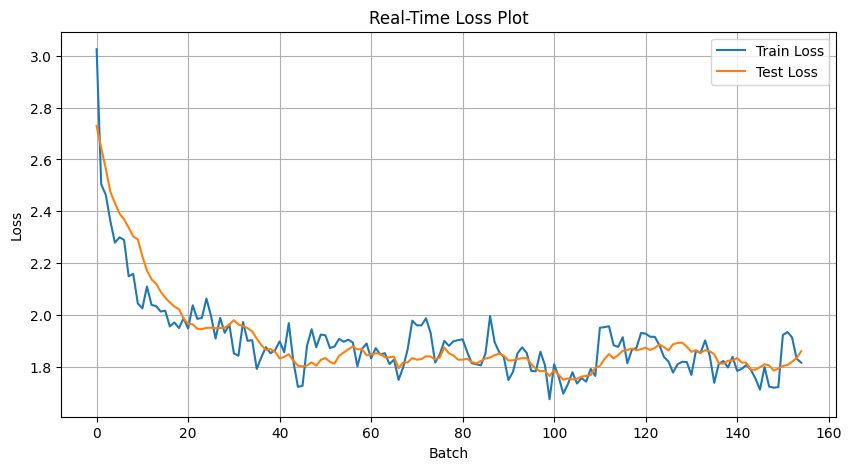

Epoch Progress:  50%|█████     | 15580/31160 [6:13:05<6:13:05,  1.44s/it, Train Avg Loss=1.76, Test Avg Loss=1.86]


(1.707219586878135,
 0.18806078880451457,
 [3.0250011576546565,
  2.5040818548202513,
  2.463646718263626,
  2.3620982468128204,
  2.2788104116916656,
  2.2997122800350187,
  2.2893243050575256,
  2.149623762369156,
  2.1583878803253174,
  2.045036265850067,
  2.025619150400162,
  2.1098954391479494,
  2.039284588098526,
  2.034173333644867,
  2.0134834277629854,
  2.0166967844963075,
  1.9561868381500245,
  1.9711942458152771,
  1.9496146106719972,
  1.9874587833881379,
  1.9481190466880798,
  2.037566388845444,
  1.9851334309577942,
  1.9888706028461456,
  2.063450976610184,
  1.9968547809123993,
  1.9091329312324523,
  1.9887429916858672,
  1.9312701308727265,
  1.9639094698429107,
  1.85190096616745,
  1.84301908493042,
  1.972920606136322,
  1.9002583885192872,
  1.902977353334427,
  1.7920663905143739,
  1.8370838630199433,
  1.876098988056183,
  1.8528295958042145,
  1.8641131901741028,
  1.8983104884624482,
  1.856555632352829,
  1.9686667442321777,
  1.8221960639953614,
  1.72

In [19]:
run_epoch(model, trainloader, trainloader, optimizer, criterion)

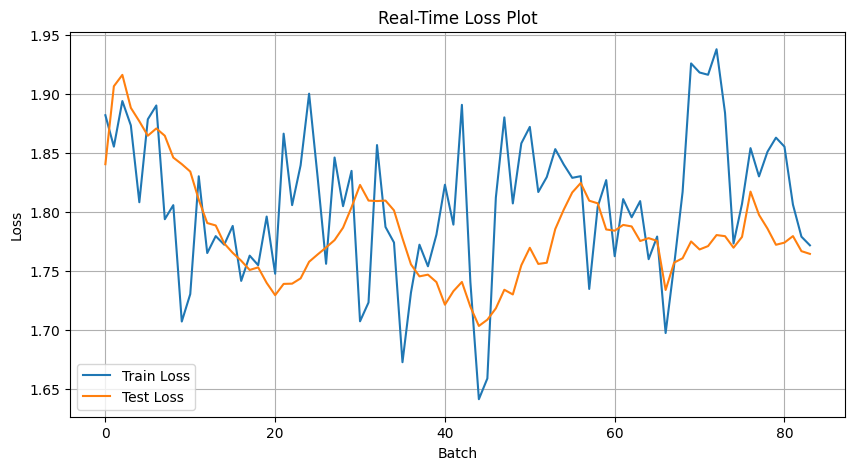

Epoch Progress:  27%|██▋       | 8421/31160 [2:59:21<8:04:18,  1.28s/it, Train Avg Loss=1.76, Test Avg Loss=1.77] 


KeyboardInterrupt: 

In [20]:
for _ in range(10):
    run_epoch(model, trainloader, trainloader, optimizer, criterion)

In [23]:
import pickle 

with open('model.pk', 'wb') as f:
    pickle.dump(model, f)

# Inference

In [21]:
def tokens_sentence(tokens: torch.Tensor):
    return [dataset_train.int_word[x] for x in tokens.tolist()]

def sentence_tokens(sentence: str):
    return torch.tensor([dataset_train.word_int[x] for x in sentence], device=device)

In [22]:
from termcolor import colored

def sample(raw_output, temperature=1):
    softmax = nn.functional.softmax(raw_output / temperature, dim=0)

    probdict = {word:p for word,p in zip(dataset_train.token_set, softmax.tolist())}
    # print({k: v for k, v in sorted(probdict.items(), key=lambda item: -item[1])})

    return torch.multinomial(softmax, num_samples=1)

def generate(model, tokens) -> torch.Tensor:
    if not type(tokens) == torch.Tensor:
        tokens = [dataset_train.word_int[x.lower()] for x in tokens]
        tokens = torch.tensor(tokens, device=device)
    
    model.eval()
    output = model(tokens.unsqueeze(0))

    return sample(output.squeeze(0), temperature=0.5)

sentence = dataset_train[0][0]
# sentence = sentence_tokens('romeo:\ni love you\njuliet:\n')

print(colored(''.join(tokens_sentence(sentence)), 'red'), end='', )

for i in range(1000):
    new_token = generate(model, sentence[-config.block_size:])
    sentence = torch.cat((sentence, new_token))
    # print(''.join(tokens_sentence(sentence)))
    print(tokens_sentence(sentence)[-1], end='')

first citizen:
before we proceed any further, hear me speak.
all:
speak, speak.
first citizen:
you are all resolved rather to die than to famish?
all:
resolved. resolved.
first citizen:
first, you know caius marcius is chief enemy to the people.
all:
we know the coppore may the to hear it the thurder morion, for the thee me ther,
thou his be of than the be stree come,
mins holy thee the last the canst there thou are that sore thee the of for our deart for the before.
juliet:
my love thou the spuret ther not there thee.
lure this mandy pary her, will the endate,
thurss you with thou the stow man the be grow,
or that the then with thes thou and the wour stirs the sore,
this not i with this the trune of the it the lation,
that a sone is and the with this were to heart.
juliet:
and it the may striend the her herse thee stongone.
juliet:
nurself my love may thurse:
the pant it me and the ene the tall son.
juliet:
i pall is the may mone the it the the hast thou that love thee thou they for t

In [173]:
generate(model, dataset[0][0])

tensor([-0.0245, -0.0144, -0.0190,  ..., -0.0163, -0.0155,  0.3842],
       device='mps:0', grad_fn=<SqueezeBackward1>)


/var/folders/bm/yls2l36s0_x_nqfllg6dm5z80000gn/T/ipykernel_38000/3616574258.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax = nn.functional.softmax(raw_output / temperature)


tensor([3864], device='mps:0')

In [176]:
alltext

"First Citizen:\nBefore we proceed any further, hear me speak.\nAll:\nSpeak, speak.\nFirst Citizen:\nYou are all resolved rather to die than to famish?\nAll:\nResolved. resolved.\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\nAll:\nWe know't, we know't.\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\nAll:\nNo more talking on't; let it be done: away, away!\nSecond Citizen:\nOne word, good citizens.\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger for bread, not in 